# "P_Delta_Analysis"
### A Tool for *Modeling*, *Bracing* & *P-Delta Analysis*
### of *Rectangular 2D Frames* with *Direct Stiffness Method*

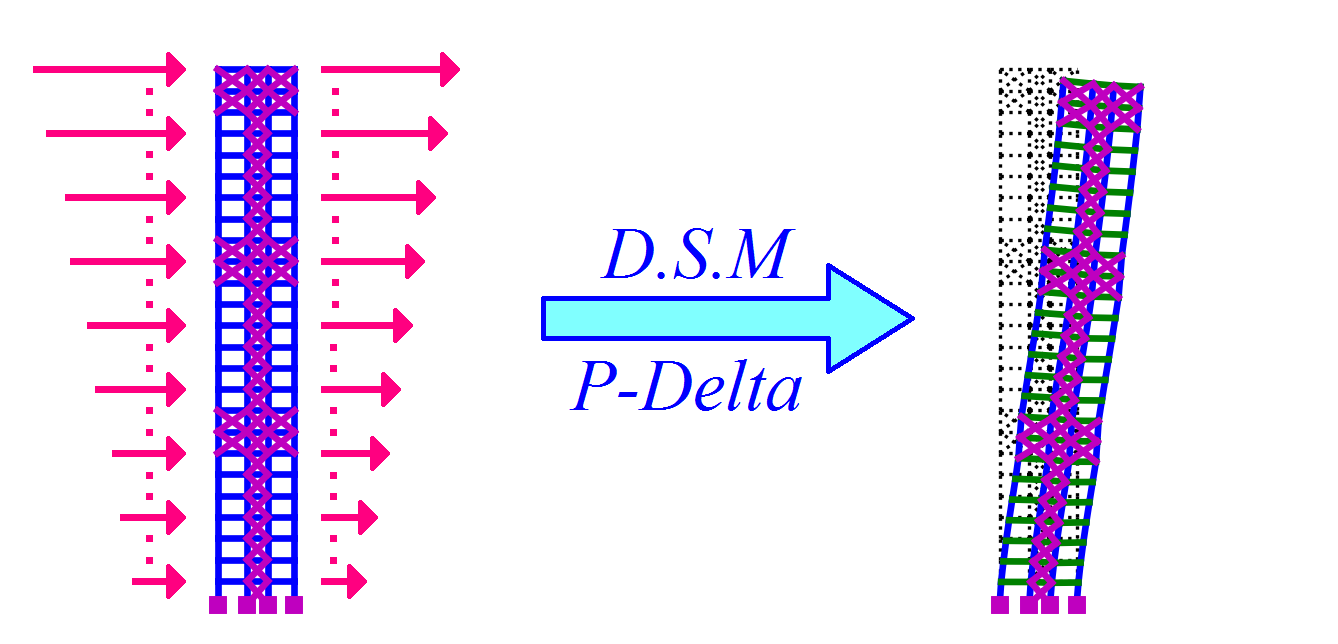

In [1]:
# (auto) importing modules needed
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt

from sympy import *
import copy

##### 
### Structure Data (input)

In [2]:
# (input)                          
wBay       = [       3190   ,   2090  ,  6050   ,  2505   ,  3070   ,  2505   ,  2855      ]  #  width of bays ( any amount )
Supports   = ['roller',  'free',  'roller', 'roller',  'free',  'roller',  'free',  'fixed']  # 'fixed' 'pinned' 'roller' 'free' 
L_tinyBeam =   150    #  length of tiny beams (mm) --- the smaller the better

# (auto) multi-sectioning
def MS( wBay, Supports, L_tinyBeam ):
    
    nBeams_Main = len(wBay)       # number of Main Beams  eg: 2
    #nSupports = nBeams_Main + 1
    wBay_Main   = wBay.copy()     # width of Main Bays    eg: 500, 600

    WBAY, SUPPORTS, NPIECES = [],[],[]
    s = 0
    SUPPORTS = [ Supports[0] ]
    for i in wBay_Main:
        nPieces  = int(i/L_tinyBeam)
        WBAY     =   WBAY   + [L_tinyBeam]*nPieces
    
        if i%L_tinyBeam >= L_tinyBeam/2: 
            WBAY = WBAY + [i%L_tinyBeam]
            nPieces = nPieces+1
        else                           : 
            WBAY[-1] = WBAY[-1]+i%L_tinyBeam 
    
        NPIECES.append( nPieces )
        s = s+1
        SUPPORTS = SUPPORTS + ['mid']*(nPieces-1) + [Supports[s]]

    SUPPORTS_IDX = [0]
    for j in NPIECES:  SUPPORTS_IDX = SUPPORTS_IDX + [ SUPPORTS_IDX[-1] + j ]

    # Assigning
    Supports     = SUPPORTS       # Type of all Supports                   eg: [ 'pinned', 'mid', 'roller', 'mid', 'fixed' ]
    Supports_Idx = SUPPORTS_IDX   # Index of Main Supports                 eg: [    0,               2,               4    ]
    wBay         = WBAY           # length of all bays (pieces)            eg: [         250 , 250    ,    300 , 300       ]
    nPieces      = NPIECES        # number of bays (pieces) in each beam   eg: [             2        ,        2           ]
    nBay         = len(WBAY)      # number of all bays (pieces)            eg: 4
    
    return [ nBeams_Main, wBay_Main, Supports, Supports_Idx, wBay, nPieces, nBay ]

# (auto) multi-sectioning
nBeams_Main, wBay_Main, Supports, Supports_Idx, wBay, nPieces, nBay = MS( wBay, Supports, L_tinyBeam )

#####   
### Points & Connectivity Matrices

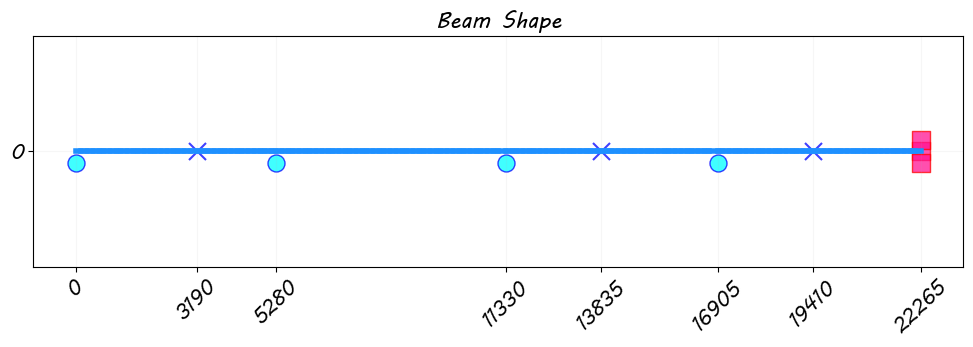

In [3]:
# (auto) Points & Connectivity Matrices
def PC( wBay ): 
    
    # Points
    Xwalk = [0]
    for i in wBay:
        w = Xwalk[-1] + i
        Xwalk.append(w)
    Ywalk = [0] 
    X=len(Xwalk)
    Y=len(Ywalk) 
    x,y, index = [],[],[]
    idx=0
    for j in range(0,Y):
        for i in range(0,X):
            x.append( int(Xwalk[i]) )
            y.append( int(Ywalk[j]) )
            index.append(idx)
            idx = idx+1
    Dict = {  'x': x
            , 'y': y  }
    Points = pd.DataFrame( data=Dict, index=index )
    
    # Connectivity
    x,y, index = [],[],[]
    idx=0
    for j in range(0,Y):
        for i in range(0,X-1): 
            p0 = i + j*X
            p1 = p0 + 1
            x.append( int(p0) )
            y.append( int(p1) )
            index.append(idx)
            idx = idx+1
    Dict = {  'from_point': x
            , 'to_point': y
           }
    CnB = pd.DataFrame( data=Dict, index=index )
    
    return [ Points, CnB ]

# (auto) Points & Connectivity Matrices
Points, CnB  =  PC( wBay )



# define a function called Shape
# to check shape of frame

def  Shape( Points, CnB, wBay, Supports ):
    
    fig, ax = plt.subplots( figsize=(12,3) )
        
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=4, c='dodgerblue', ls='-' )

    for i in Points.index:
        x = Points.loc[i,'x']
        y = Points.loc[i,'y']
        if   Supports[i]=='fixed' : marker, ec, fc, y = 's', 'r', 'deeppink', y-0.0
        elif Supports[i]=='pinned': marker, ec, fc, y = '^', 'g', 'lime'    , y-0.1
        elif Supports[i]=='roller': marker, ec, fc, y = 'o', 'b', 'cyan'    , y-0.1
        elif Supports[i]=='free'  : marker, ec, fc, y = 'x', 'b', 'b'       , y-0.0
        elif Supports[i]=='mid'   : marker, ec, fc, y = '' , 'b', 'b'       , y-0.0
        ax.scatter( x, y, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        if   Supports[i]=='fixed' :
            ax.scatter( x, y+0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
            ax.scatter( x, y-0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        
    # title
    plt.title( 'Beam Shape', font='MV BOLI', fontsize=16 )
    
    # xticks
    Xwalk = [0]
    for i in wBay_Main:
        w = Xwalk[-1] + i 
        Xwalk.append(w)
    xtks = np.array(Xwalk,dtype='f8')
    ax.set_xticks( xtks )
    plt.xticks(font='MV BOLI',rotation=45,fontsize=14) 
    
    # yticks
    Ywalk = [0]
    ytks = np.array(Ywalk,dtype='f8')
    ax.set_yticks( ytks )
    plt.yticks(font='MV BOLI',rotation=0,fontsize=14)
    
    # ylim
    plt.ylim([-1,+1])
    
    # grid
    plt.grid('on',alpha=.1)
    
    # save image
    plt.savefig('Beam_Shape.png', dpi=120) 
    plt.show()
    
# (auto) checking shape of frame
Shape( Points, CnB, wBay, Supports )

#####   
### Finding Static Coefficients

In [4]:
# (auto) Coefficients

# define a function called Static_Coeff 
# to find Static Analysis Coefficients: 
#
#   NOP:    Number Of Points
#   NOD:    Number of "Degrees of freedom"
#   RD:     Restrained "Degrees of freedom"
#   FD:     Free "Degrees of freedom"
#   NFD:    Number of Free "Degrees of Freedom"
#   NB:     Number of Beams
#   IndxB:  ['near_x','near_y','near_z','far_x','far_y','far_z']  of  all beams

def Static_Coeff( Points, CnB, wBay, Supports ):
    
    # NOP NOD RD FD NFD
    NOP=Points.shape[0]
    NOD=NOP*3
    
    RD=[]
    for i in Points.index:
        if   Supports[i]=='fixed' : LIST=[ 3*i+0, 3*i+1, 3*i+2 ]
        elif Supports[i]=='pinned': LIST=[ 3*i+0, 3*i+1        ]
        elif Supports[i]=='roller': LIST=[        3*i+1        ]
        elif Supports[i]=='free'  : LIST=[                     ]
        elif Supports[i]=='mid'   : LIST=[                     ]
        for i in LIST:
            RD.append(i)
    
    FD=[]
    for i in range(NOD):
        if i not in RD:
            FD.append(i)
    
    NRD=len(RD)
    NFD=len(FD)
    
    # NX
    NB = CnB.shape[0]
    
    # IndxB
    c0,c1,c2, c3,c4,c5 = [],[],[], [],[],[]
    index, idx = [], 0  
    for i in range( 0, NB ):
        c0.append( 3*CnB.iloc[i,0]+0 )
        c1.append( 3*CnB.iloc[i,0]+1 )
        c2.append( 3*CnB.iloc[i,0]+2 )
        c3.append( 3*CnB.iloc[i,1]+0 )
        c4.append( 3*CnB.iloc[i,1]+1 )
        c5.append( 3*CnB.iloc[i,1]+2 )
        index.append(idx)
        idx = idx+1 
    Dict = {  'near_x':c0  ,  'near_y':c1  ,  'near_z' : c2
            , 'far_x' :c3  ,  'far_y' :c4  ,  'far_z'  : c5
        }
    IndxB = pd.DataFrame( data=Dict, index=index )
    
    return [NOP, NOD, RD, FD, NFD, NB, IndxB]
    
    
# (auto) Finding Static Coefficients
[NOP, NOD, RD, FD, NFD, NB, IndxB] = Static_Coeff( Points, CnB, wBay, Supports )

#####   
## Assigning

##### 
### Beams

In [5]:
# help
print( 'There are '+str(nBeams_Main)+' beams' )

There are 7 beams


In [6]:
# input

# material  ---  Modulus of Elasticity  ---  Concrete = 30  ---  Steel = 200  ---  (KN/mm2)
Ec = 30
E_Beams = [ Ec ] * nBeams_Main


# sections
# (input)        (auto)      
b,h = 500,900;   s1 = [ b*h, b*h**3/12 ]
b,h = 500,950;   s2 = [ b*h, b*h**3/12 ]
b,h = 600,950;   s3 = [ b*h, b*h**3/12 ]

Sections = [ s3, s3, s1, s2, s2, s1, s1 ]


# rectangular Distributed Load on Beams  (KN/mm)
# towards Ground is +ve 
W_Beams  = [ 0.04875, 0.04875, 0.0325, 0.04875, 0.04875, 0.0325, 0.0325 ]   

 

# (auto) multi-applying  ---  applying  E, A, I, W  to all pieces
def Multi_Beams( E_Beams, Sections, W_Beams, nPieces ):
    A_Beams, I_Beams = [],[];
    for i in range(len(Sections)):   
        A_Beams.append( int(Sections[i][0]) )
        I_Beams.append( int(Sections[i][1]) )
    
    E_BEAMS, A_BEAMS, I_BEAMS, W_BEAMS = [],[],[],[]
    for i in range(nBeams_Main):
        E_BEAMS  =  E_BEAMS  +  [ E_Beams[i] ] * nPieces[i]
        A_BEAMS  =  A_BEAMS  +  [ A_Beams[i] ] * nPieces[i]
        I_BEAMS  =  I_BEAMS  +  [ I_Beams[i] ] * nPieces[i]
        W_BEAMS  =  W_BEAMS  +  [ W_Beams[i] ] * nPieces[i]

    #E_Beams = E_BEAMS
    #A_Beams = A_BEAMS
    #I_Beams = I_BEAMS
    #W_Beams = W_BEAMS
    
    Beams = pd.DataFrame(columns=['E','A','I','W'])
    Beams['E'], Beams['A'], Beams['I'], Beams['W'] = E_BEAMS, A_BEAMS, I_BEAMS, W_BEAMS
    
    return Beams

# (auto) multi-applying  ---  applying  E, A, I, W  to all pieces
Beams = Multi_Beams( E_Beams, Sections, W_Beams, nPieces )
Beams.head(3)

,E,A,I,W
0,30,570000,42868750000,0.04875
1,30,570000,42868750000,0.04875
2,30,570000,42868750000,0.04875


In [7]:
def Beam_Color( Beams ):
    
    Colors = ['dodgerblue','deeppink','lawngreen','orange','purple','olive','pink']
    df = Beams[['E','A','I']].copy()

    df_Set = df.copy().drop_duplicates()
    df_Set.index = range( df_Set.shape[0] )
    df_Set['C'] = Colors[:df_Set.shape[0]]

    C = []
    for j in range(df.shape[0]):
        A = df.loc[j,'A']
        I = df.loc[j,'I']
        for i in range(df_Set.shape[0]):
            set_A, set_I, set_C = df_Set.loc[i,['A','I','C']]
            if set_A==A and set_I==I: C.append(set_C)
                
    return C


Beams['C'] = Beam_Color( Beams )

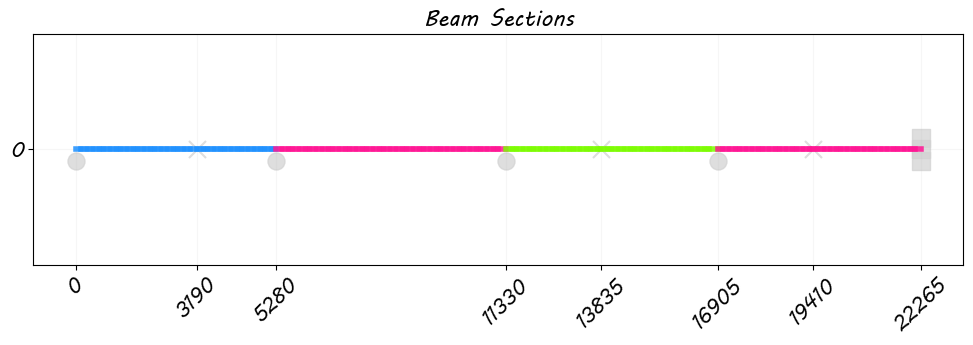

In [8]:
# define a function called Shape
# to check shape of frame

def Plot_Sections( Points, CnB, wBay, Supports, Beams ):
    
    fig, ax = plt.subplots( figsize=(12,3) )
        
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        c = Beams.loc[i,'C']
        ax.plot( x, y, lw=4, c=c, ls='-', alpha=0.85 )

    for i in Points.index:
        x = Points.loc[i,'x']
        y = Points.loc[i,'y']
        if   Supports[i]=='fixed' : marker, ec, fc, y = 's', 'lightgray', 'lightgray', y-0.0
        elif Supports[i]=='pinned': marker, ec, fc, y = '^', 'lightgray', 'lightgray'    , y-0.1
        elif Supports[i]=='roller': marker, ec, fc, y = 'o', 'lightgray', 'lightgray'    , y-0.1
        elif Supports[i]=='free'  : marker, ec, fc, y = 'x', 'lightgray', 'lightgray'       , y-0.0
        elif Supports[i]=='mid'   : marker, ec, fc, y = '' , 'lightgray', 'lightgray'       , y-0.0
        ax.scatter( x, y, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        if   Supports[i]=='fixed' :
            ax.scatter( x, y+0.1, marker=marker, s=150, ec='lightgray', fc='lightgray', alpha=0.75 )
            ax.scatter( x, y-0.1, marker=marker, s=150, ec='lightgray', fc='lightgray', alpha=0.75 )
        
    # title
    plt.title( 'Beam Sections', font='MV BOLI', fontsize=16 )
    
    # xticks
    Xwalk = [0]
    for i in wBay_Main:
        w = Xwalk[-1] + i 
        Xwalk.append(w)
    xtks = np.array(Xwalk,dtype='f8')
    ax.set_xticks( xtks )
    plt.xticks(font='MV BOLI',rotation=45,fontsize=14) 
    
    # yticks
    Ywalk = [0]
    ytks = np.array(Ywalk,dtype='f8')
    ax.set_yticks( ytks )
    plt.yticks(font='MV BOLI',rotation=0,fontsize=14)
    
    # ylim
    plt.ylim([-1,+1])
    
    # grid
    plt.grid('on',alpha=.1)
    
    # save image
    plt.savefig('Beam_Sections.png', dpi=120)
    plt.show()
    
# (auto) checking shape of frame
Plot_Sections( Points, CnB, wBay, Supports, Beams )

##### 
### Checking Beam Load

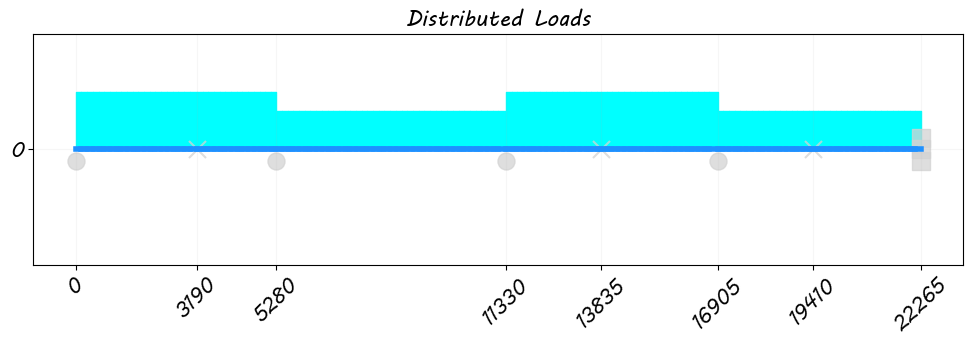

In [9]:
# define a function called Beam_Load_Shape
# to check load of beams

def  Beam_Dist_Load_Shape( Points, CnB, wBay, Supports, Beams ):
    
    fig, ax = plt.subplots( figsize=(12,3) )
        
    W = Beams['W'].copy()
    W = W / W.max() / 2
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        y2 = [ y0+W[i], y1+W[i] ]
        ax.fill_between(x, y, y2, color='cyan')
        ax.plot( x, y, lw=4, c='dodgerblue', ls='-' )

    for i in Points.index:
        x = Points.loc[i,'x']
        y = Points.loc[i,'y']
        if   Supports[i]=='fixed' : marker, ec, fc, y = 's', 'lightgray', 'lightgray', y-0.0
        elif Supports[i]=='pinned': marker, ec, fc, y = '^', 'lightgray', 'lightgray', y-0.1
        elif Supports[i]=='roller': marker, ec, fc, y = 'o', 'lightgray', 'lightgray', y-0.1
        elif Supports[i]=='free'  : marker, ec, fc, y = 'x', 'lightgray', 'lightgray', y-0.0
        elif Supports[i]=='mid'   : marker, ec, fc, y = '' , 'lightgray', 'lightgray', y-0.0
        ax.scatter( x, y, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        if   Supports[i]=='fixed' :
            ax.scatter( x, y+0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
            ax.scatter( x, y-0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        
    # title
    plt.title( 'Distributed Loads', font='MV BOLI', fontsize=16 )
    
    # xticks
    Xwalk = [0]
    for i in wBay_Main:
        w = Xwalk[-1] + i 
        Xwalk.append(w)
    xtks = np.array(Xwalk,dtype='f8')
    ax.set_xticks( xtks )
    plt.xticks(font='MV BOLI',rotation=45,fontsize=14) 
    
    # yticks
    Ywalk = [0]
    ytks = np.array(Ywalk,dtype='f8')
    ax.set_yticks( ytks )
    plt.yticks(font='MV BOLI',rotation=0,fontsize=14)
    
    # ylim
    plt.ylim([-1,+1])
    
    # grid
    plt.grid('on',alpha=.1)
    
    # save image
    plt.savefig('Distributed_Loads.png', dpi=120)
    plt.show()
    
Beam_Dist_Load_Shape( Points, CnB, wBay, Supports, Beams )

##### 
### Nodal Forces

In [10]:
# help
print( 'There are '+str( nBeams_Main+1 )+' support(s)' )

There are 8 support(s)


In [11]:
# (input) towards Ground is +ve 
Point_Loads = [0,50,0,0,50,0,100,0]  # (KN)  only on "free" supports. other supports = 0

# (auto) Nodal Forces
def Nodal_Forces( Points, Point_Loads, NOD ): 
    
    # Multi-Sectioning
    PL = [0]
    for i in range(nBeams_Main):
        PL[-1] = Point_Loads[i]
        PL = PL + [0]*nPieces[i]
    PL[-1] = Point_Loads[-1]
    Point_Loads = PL
    
    NF = pd.DataFrame( columns=['Load','Dummy'], index=range(NOD) ).replace( float('nan'), 0.0 )
    for  i in Points.index:  NF.loc[3*i+1,'Load'] = -Point_Loads[i]
    #for i in Points.index:  NF.loc[3*i  ,'Load'] = +0.001 # disturbing load
    return NF

# (auto) Nodal Forces
NF = Nodal_Forces( Points, Point_Loads, NOD )

#####   
### Checking NF

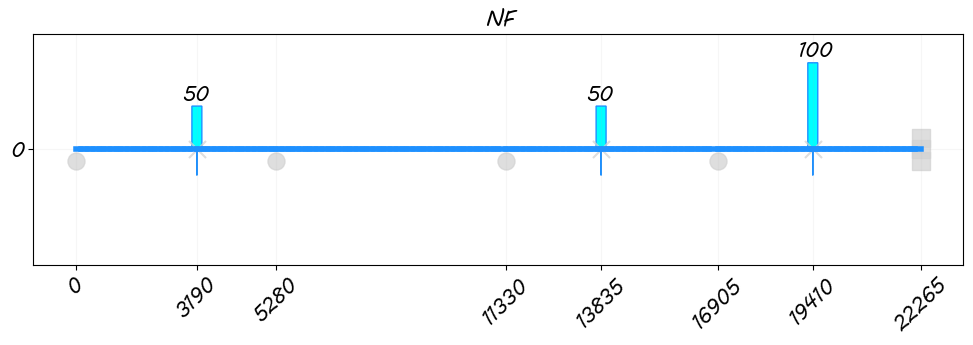

In [12]:
# define a function called Point_Load_Shape
# to check NF of beams

def  Point_Load_Shape( Points, CnB, wBay, NF ):
    
    fig, ax = plt.subplots( figsize=(12,3) )
        
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=4, c='dodgerblue', ls='-' )
    
    y_Max = max(abs(NF['Load']))
    w = sum(wBay)/85
    for i in NF.index: 
        if  i % 3 == 1:
            x = Points.loc[ (i-1)/3, 'x' ]
            y = NF.loc[i,'Load'] / y_Max *.75
            if   y>0:  
                ax.arrow( x, -y, 0, y, head_width=.15, width=w, fc='pink', ec='deeppink'   )
                plt.text( x-1.5*w, -y-.20, str(int(+NF.loc[i,'Load'])), font='MV BOLI', fontsize=14 )
            elif y<0: 
                ax.arrow( x, -y, 0, y, head_width=.15, width=w, fc='cyan', ec='dodgerblue' )  
                plt.text( x-1.5*w, -y+.05, str(int(-NF.loc[i,'Load'])), font='MV BOLI', fontsize=14 )  
            

    for i in Points.index:
        x = Points.loc[i,'x']
        y = Points.loc[i,'y']
        if   Supports[i]=='fixed' : marker, ec, fc, y = 's', 'lightgray', 'lightgray', y-0.0
        elif Supports[i]=='pinned': marker, ec, fc, y = '^', 'lightgray', 'lightgray', y-0.1
        elif Supports[i]=='roller': marker, ec, fc, y = 'o', 'lightgray', 'lightgray', y-0.1
        elif Supports[i]=='free'  : marker, ec, fc, y = 'x', 'lightgray', 'lightgray', y-0.0
        elif Supports[i]=='mid'   : marker, ec, fc, y = '' , 'lightgray', 'lightgray', y-0.0 
        ax.scatter( x, y, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        if   Supports[i]=='fixed' :
            ax.scatter( x, y+0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
            ax.scatter( x, y-0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        
    # title
    plt.title( 'NF', font='MV BOLI', fontsize=16 )
    
    # xticks
    Xwalk = [0]
    for i in wBay_Main:
        w = Xwalk[-1] + i 
        Xwalk.append(w)
    xtks = np.array(Xwalk,dtype='f8')
    ax.set_xticks( xtks )
    plt.xticks(font='MV BOLI',rotation=45,fontsize=14) 
    
    # yticks
    Ywalk = [0]
    ytks = np.array(Ywalk,dtype='f8')
    ax.set_yticks( ytks )
    plt.yticks(font='MV BOLI',rotation=0,fontsize=14)
    
    # ylim
    plt.ylim([-1,+1])
    
    # grid
    plt.grid('on',alpha=.1)
    
    # save image
    plt.savefig('NF.png', dpi=120)
    plt.show()
    
    return None
                
        
# (auto) Checking NF
Point_Load_Shape( Points, CnB, wBay, NF )

#####   
### Elastic Stiffness Matrices 

In [13]:
# (auto) defining Stiffness Matrices
def ke_frame( A, E, I, L ):
    EI, EA, L2, L3 = E*I, E*A, L**2, L**3
    r = [  'c1', 'c2', 'c3', 'c4', 'c5', 'c6'  ] 
    c = {  'c1': [ EA/L   , 0        ,  0      , -1*EA/L,  0       ,  0       ]
         , 'c2': [ 0      , 12*EI/L3 ,  6*EI/L2,  0     , -12*EI/L3,  6*EI/L2 ]
         , 'c3': [ 0      , 6*EI/L2  ,  4*EI/L ,  0     , -6*EI/L2 ,  2*EI/L  ]
         , 'c4': [-1*EA/L , 0        ,  0      ,  EA/L  ,  0       ,  0       ]
         , 'c5': [ 0      , -12*EI/L3, -6*EI/L2,  0     ,  12*EI/L3, -6*EI/L2 ]  
         , 'c6': [ 0      , 6*EI/L2  , 2*EI/L  ,  0     , -6*EI/L2 ,  4*EI/L  ] 
         }  
    df = pd.DataFrame( data=c , index=r )
    return df

def T_frame( c, s ): 
    r = [  'c1', 'c2', 'c3', 'c4', 'c5', 'c6' ] 
    c = {  'c1': [  c  ,  s  ,   0  ,  0  ,  0  ,   0  ]  
         , 'c2': [ -s  ,  c  ,   0  ,  0  ,  0  ,   0  ]
         , 'c3': [  0  ,  0  ,   1  ,  0  ,  0  ,   0  ]
         , 'c4': [  0  ,  0  ,   0  ,  c  ,  s  ,   0  ]
         , 'c5': [  0  ,  0  ,   0  , -s  ,  c  ,   0  ]
         , 'c6': [  0  ,  0  ,   0  ,  0  ,  0  ,   1  ]
         }  
    df = pd.DataFrame( data=c , index=r )
    return df.T

#####  
### Ke & Qf

In [14]:
# (auto) defining a function called KeQf
# to form:
#    Elastic Stiffness Matrices, Ke, for all elements
#    External Distributed Loads Matrix, Qf

def KeQf(  Points,  NOD
         , CnB, NB, IndxB, Beams ):
    
    # Empty Ke Qf
    KE = np.zeros([NOD,NOD],'float64')
    KE = pd.DataFrame( KE,columns = np.arange(0,NOD) )
    QF = np.zeros([NOD,2],'float64')
    QF = pd.DataFrame( QF,columns = ['Load','Dummy'] )
    
    # Assigning Properties  
    LB,  TB,  keB,  KeB, qfB, QfB  =  [],[],[],[],[],[]
        
    for i in range(0,NB): 
        dx = Points.iloc[CnB.iloc[i,1],0]-Points.iloc[CnB.iloc[i,0],0]
        dy = Points.iloc[CnB.iloc[i,1],1]-Points.iloc[CnB.iloc[i,0],1]
        L  = (dx**2+dy**2)**0.5;     LB.append(L)
        E  = Beams.loc[i,'E'];      
        A  = Beams.loc[i,'A'];         
        I  = Beams.loc[i,'I'];          
        w  = Beams.loc[i,'W'];          
        c,s= dx/L, dy/L;
        T  = T_frame(c,s);           TB.append(T)
        Indx = list(IndxB.iloc[i,:])
        qf   = [0,w*L/2,w*L**2/12,0,w*L/2,-w*L**2/12] 
        Dict = {'qf':qf, 'dummy':np.zeros(6,'float')}
        qf = pd.DataFrame( data=Dict, index=range(0,6) ) 
        qfB.append(qf)
        Qf = T.T @ qf['qf'].values;                              
        QF.loc[Indx,'Load'] = QF.loc[Indx,'Load'] + Qf.values;
        ke = ke_frame(A,E,I,L);      keB.append(ke)   
        Ke = T.T @ ke @ T;           KeB.append(Ke)
        KE.iloc[Indx,Indx] = KE.iloc[Indx,Indx]+Ke.values;
    Beams['L'] = LB
    
    return [ KE,QF, LB,TB,keB,KeB,qfB ]


# Ke Qf 
KE,QF, LB,TB,keB,KeB,qfB  =  KeQf( Points,  NOD, CnB, NB, IndxB, Beams )

#####   
### P-Delta Analysis

In [15]:
# (auto) define a function called P-Delta
# to perform the analysis

print('Analysis initiated ...')
def P_Delta( NF,  NOD,  FD, KE, QF
           , NB, IndxB, TB, keB, KeB, Beams, qfB ): 
            
    ## k  kX KX  
    K=KE
            
    kB, KB = [],[];
    for i in range(0,NB): 
        kB.append( keB[i] )
        KB.append( KeB[i] )    
     
    # Kred
    Kred = K.iloc[FD,FD]
        
    # U
    U = np.zeros([NOD,2],'float64')
    U = pd.DataFrame( U,columns = ['dis','Dummy'] ) 
         
    ## Gauss Ellimination  ax=b => x=?
    a = Kred.values
    b = (  NF.loc[FD,'Load'] - QF.loc[FD,'Load']  ).values
    n = len(b)
    x = np.zeros(n,'float64')

    #    Forward Elimination
    for k in range(n-1):
        for i in range(k+1,n):
            fctr = a[i,k] / a[k,k]
            for j in range(k,n):
                a[i,j] = a[i,j] - fctr*a[k,j]
            b[i] = b[i] - fctr*b[k]
    
    #    Back Substitution
    x[n-1] = b[n-1] / a[n-1,n-1]
    for i in range(n-2,-1,-1):
        Sum = b[i]
        for j in range(i+1,n):
            Sum = Sum - a[i,j]*x[j]
        x[i] = Sum / a[i,i]
           
    # U    
    U.loc[FD,'dis'] = x.copy()
        
    ## member forces
      
    #    Beam
    uB,UB,qB = [],[],[]
    for i in range(0,NB):
        Indx = list(IndxB.iloc[i,:])
        T    = TB[i] 
        k    = kB[i] 
        UB.append(  U.loc[Indx,'dis'].values  )    
        uB.append( T @ UB[-1] )
        qB.append( k @ uB[-1] )
         
    ## Reactions 
    R = np.zeros([NOD,2],'float64')
    R = pd.DataFrame( R, columns = ['Reactions','Dummy'] )
        
    #   Beam
    for i in range(0,NB):
        Indx = list(IndxB.iloc[i,:])
        T    = TB[i]
        q    = qB[i]
        Q    = T.T @ q  
        R.loc[Indx,'Reactions'] = R.loc[Indx,'Reactions'] + Q.values   
    
    return [ qB, R, U ]


# P-Delta Analysis
qB, R, U = P_Delta( NF,  NOD,  FD, KE,  QF
                  , NB, IndxB, TB, keB, KeB, Beams, qfB )

print('Done')

Analysis initiated ...
Done


#####   
### Converting +ve directions
Direct Stiffness Method has a +ve direction convension for axial-load, shear and bending-moment which is different from Standard Static +ve direction convensions; and will be corrected.

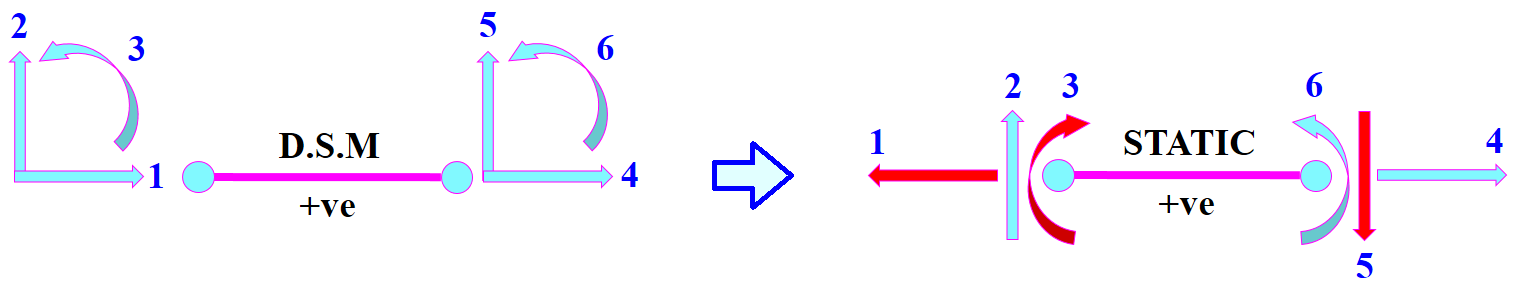

In [16]:
# (auto) define a function called D2S
# o convert Direct Stiffness Method +ve direction
# to Standard Static +ve direction

def D2S( NB, qB, R  ):
    
    qBs = copy.deepcopy(qB) 
    for i in range(0,NB):
        for j in [0,2,4]: qBs[i].iloc[j] = -qBs[i].iloc[j]
            
    return [ qBs ]


# Converting Directions (D.S.M. to Standard.Static) 
# qX  --->  qXs
[ qBs ] = D2S( NB, qB, R )

#####   
### Global Displacements, Support Reactions & Internal Member Forces

In [17]:
# (auto) define a function called xyzNVM
# to generate Global Displacements, Structural Reaction, & Internal Member Forces

def xyzNVM( NB, U, R, qBs, nBay ):
        
    Ux = list( U.loc[ np.arange(0,len(U),3), 'dis' ] )
    Uy = list( U.loc[ np.arange(1,len(U),3), 'dis' ] )
    Uz = list( U.loc[ np.arange(2,len(U),3), 'dis' ] )
    index = np.arange(0,len(U)/3)
    Dict={'Ux':Ux,'Uy':Uy,'Uz':Uz}; Uxyz=pd.DataFrame(data=Dict,index=index)
    
    Rx = list( R.loc[ np.arange(0,len(R),3), 'Reactions' ] )
    Ry = list( R.loc[ np.arange(1,len(R),3), 'Reactions' ] )
    Rz = list( R.loc[ np.arange(2,len(R),3), 'Reactions' ] )
    index = np.arange(0,len(R)/3)
    Dict={'Rx':Rx,'Ry':Ry,'Rz':Rz}; Rxyz=pd.DataFrame(data=Dict,index=index)
    n = nBay+1;                     Rxyz=round( Rxyz.iloc[range(0,n),:], 2 )
            
    # Beam: left right    
    AxB_l, AxB_r, VB_l, VB_r, MB_l, MB_r = [],[],[],[],[],[]
    for i in range(0,NB):
        AxB_l.append( qBs[i].iloc[0] )
        AxB_r.append( qBs[i].iloc[3] )
        VB_l.append(  qBs[i].iloc[1] )
        VB_r.append(  qBs[i].iloc[4] )
        MB_l.append(  qBs[i].iloc[2] )
        MB_r.append(  qBs[i].iloc[5] )
    index=np.arange(0,NB)
    Dict={'left':AxB_l,'right':AxB_r}; AxB=pd.DataFrame(data=Dict,index=index)
    Dict={'left':VB_l, 'right':VB_r};   VB=pd.DataFrame(data=Dict,index=index)
    Dict={'left':MB_l, 'right':MB_r};   MB=pd.DataFrame(data=Dict,index=index)
    
    return [ Uxyz, Rxyz, AxB,VB,MB ]


# xyzNVM
[ Uxyz, Rxyz, AxB,VB,MB ] = xyzNVM( NB, U, R, qBs, nBay )

##### 
### Adding Member-Forces to Elements DataFrame

In [18]:
def Add_member_forces( AxB,VB,MB, Beams ):

    # Beams
    Beams['Axial_Load'  ] = (np.round(  AxB['right'].values   ,0)).astype('int64')
    Beams['Shear_left'  ] = (np.round(  VB['left'  ].values   ,0)).astype('int64')
    Beams['Shear_right' ] = (np.round(  VB['right' ].values   ,0)).astype('int64')
    Beams['Moment_left' ] = (np.round(  MB['left'  ].values  ,-2)).astype('int64')
    Beams['Moment_right'] = (np.round(  MB['right' ].values  ,-2)).astype('int64')
    
    return [ Beams ]

# Adding Internal Forces to Elements DataFrames
[ Beams ]  =  Add_member_forces( AxB,VB,MB, Beams )

#####   
### Plotting Deformed Shape + Shear
##### ( set the Scale manually )

In [19]:
# define a function to find Max or Min Uy of Main bays

def Find_Uy_MxMn( Points, Uxyz, Supports_Idx, nBeams_Main ):
    
    A = pd.concat( [ Points, Uxyz.loc[:,['Uy']] ], axis=1 )
    B = Supports_Idx.copy()
    
    X,Y,Uy = [],[],[]
    for i in range( nBeams_Main ):
        C = A.copy().loc[ list(np.arange(B[i],B[i+1]+1)), : ]   # finding first-to-last indexes of a bay
        D = abs(C).sort_values( ['Uy'], ascending=[False] )     # sorting bay |Uy|  (max to min)
        I = D.index.tolist()[0]                                 # finding MxMn index
        x  = np.round( C.loc[I,'x' ], 0 );    X.append(x)       # finding MxMn x
        y  = np.round( C.loc[I,'y' ], 0 );    Y.append(y)       # finding MxMn y
        uy = np.round( C.loc[I,'Uy'], 1 );   Uy.append(uy)      # finding MxMn Uy
        
    df = pd.DataFrame()
    df['X' ] = X  
    df['Y' ] = Y  
    df['Uy'] = Uy
    df.index = range(df.shape[0])
    
    # dropping duplicates
    df = df.drop_duplicates()
    df.index = range(df.shape[0])
    
    # removing close values (minors)
    Keep = []
    for i in range(df.shape[0]-1):
        if df.loc[i,'X'] <= 0.90*df.loc[i+1,'X']:   Keep.append(i)
    i = df.shape[0]-1
    if df.loc[i,'X'] >= 0.90*df.loc[i-1,'X']:   Keep.append(df.shape[0]-1)
    df = df.loc[Keep,:]
    df.index = range(df.shape[0])
        
    # adding Uy of 'free' supports
    for i in Supports_Idx:
        if Supports[i] == 'free': 
            x  = np.round( A.loc[i,'x' ], 0 )
            y  = np.round( A.loc[i,'y' ], 0 )
            Uy = np.round( A.loc[i,'Uy'], 1 )
            new = pd.DataFrame([x,y,Uy]).T
            new.columns=['X','Y','Uy']
            new.index  =[df.shape[0]] 
            df = pd.concat([df,new],axis=0)
    
    # dropping duplicates
    df = df.drop_duplicates()
    df.index = range(df.shape[0])
    
    df = df.sort_values(['X'],ascending=[True])
    df.index = range(df.shape[0])
    
    Uy_MxMn = df
    return Uy_MxMn

Uy_MxMn = Find_Uy_MxMn( Points, Uxyz, Supports_Idx, nBeams_Main )
Uy_MxMn

,X,Y,Uy
0,2550.0,0.0,-0.3
1,3190.0,0.0,-0.3
2,6330.0,0.0,0.0
3,13835.0,0.0,-0.2
4,13985.0,0.0,-0.2
5,19410.0,0.0,-0.1
6,19560.0,0.0,-0.1


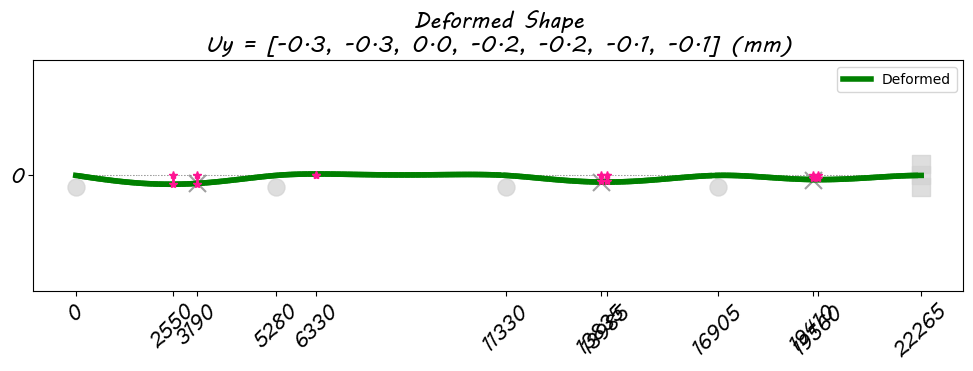

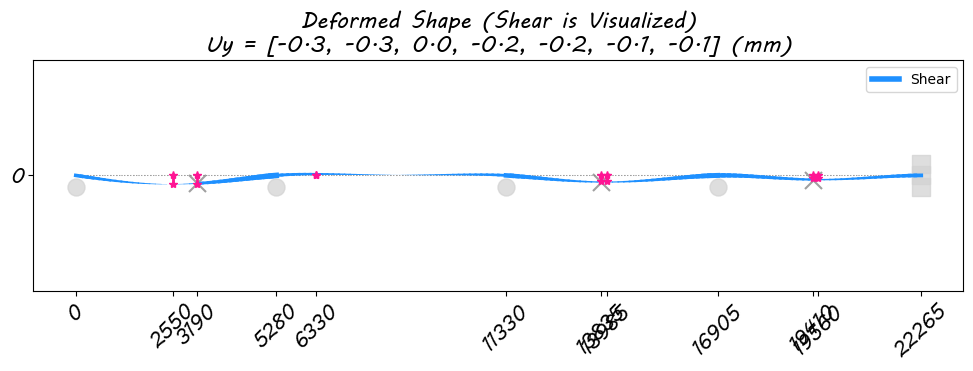

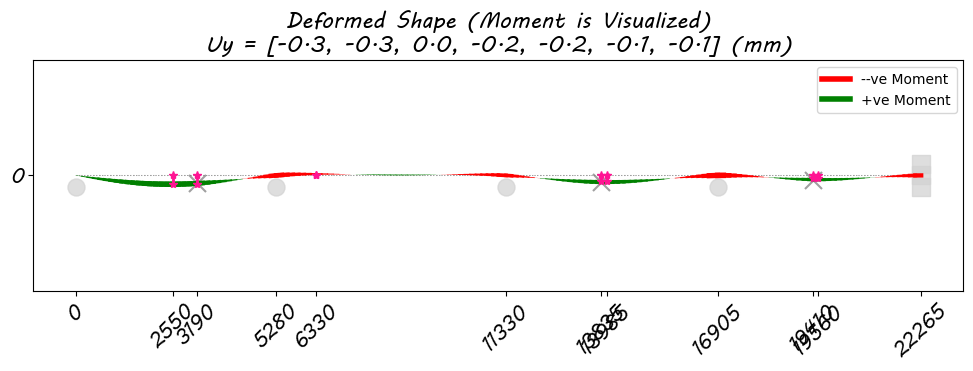

In [20]:
def Plot_Deformed( Scale, Points, Uxyz, Beams, CnB,NB, wBay, Uy_MxMn, VM ):
    
    NewX = Points['x']+Uxyz['Ux']*Scale
    NewY = Points['y']+Uxyz['Uy']*Scale
    
    NewPoints = Points.copy() 
    NewPoints['x']=NewX.copy()
    NewPoints['y']=NewY.copy()
    
    fig, ax = plt.subplots( figsize=(12,3) )
    
    # Undeformed
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=.75, c='gray', ls=':' )

    # deformed        
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = NewPoints.loc[i0,'x']
        x1 = NewPoints.loc[i1,'x']
        y0 = NewPoints.loc[i0,'y']
        y1 = NewPoints.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        if VM not in ['V','M']:
            ax.plot( x, y, lw=4, c='g', ls='-' )
    
    # Shear
    Beam_Shear = Beams['Shear_left']+Beams['Shear_right']
    LW = abs(  Beam_Shear / abs(Beam_Shear).max() ) * 4
    for i in CnB.index:
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = NewPoints.loc[i0,'x']
        x1 = NewPoints.loc[i1,'x']
        y0 = NewPoints.loc[i0,'y']
        y1 = NewPoints.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        if VM == 'V':
            ax.plot( x, y, lw=LW[i], c='dodgerblue', ls='-' )
        
    
    # Moment
    Beam_Moment = (Beams['Moment_left']+Beams['Moment_right'])/2
    LW = abs(  Beam_Moment / abs(Beam_Moment).max() ) * 4
    ML = Beams['Moment_left' ] / abs(Beam_Moment).max()
    MR = Beams['Moment_right'] / abs(Beam_Moment).max()
    for i in CnB.index:
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = NewPoints.loc[i0,'x']
        x1 = NewPoints.loc[i1,'x']
        y0 = NewPoints.loc[i0,'y']
        y1 = NewPoints.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        if Beam_Moment[i] >=0:  c='g'
        else                 :  c='r'
        if VM == 'M':
            ax.plot( x, y, lw=LW[i], c=c, ls='-' )
        
        
    for i in Uy_MxMn.index:
        x0 = Uy_MxMn.loc[i,'X']
        x1 = Uy_MxMn.loc[i,'X']
        y0 = 0
        y1 = Uy_MxMn.loc[i,'Uy']*Scale
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=2, c='deeppink', ls='-', marker='*' )
        

    for i in NewPoints.index:
        x = NewPoints.loc[i,'x']
        y = NewPoints.loc[i,'y']
        if   Supports[i]=='fixed' : marker, ec, fc, y = 's', 'lightgray', 'lightgray', y-0.0
        elif Supports[i]=='pinned': marker, ec, fc, y = '^', 'lightgray', 'lightgray', y-0.1
        elif Supports[i]=='roller': marker, ec, fc, y = 'o', 'lightgray', 'lightgray', y-0.1
        elif Supports[i]=='free'  : marker, ec, fc, y = 'x',      'gray',      'gray', y-0.0
        elif Supports[i]=='mid'   : marker, ec, fc, y = '' ,      'gray',      'gray', y-0.0
        ax.scatter( x, y, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        if   Supports[i]=='fixed' :
            ax.scatter( x, y+0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
            ax.scatter( x, y-0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        
    # title
    if   VM not in ['V','M']:   TITLE = 'Deformed Shape'
    elif VM == 'V'          :   TITLE = 'Deformed Shape (Shear is Visualized)'
    elif VM == 'M'          :   TITLE = 'Deformed Shape (Moment is Visualized)'
    plt.title( TITLE+'\nUy = '+str(Uy_MxMn['Uy'].tolist())+' (mm)', font='MV BOLI', fontsize=16 )
    
    # xticks
    Xwalk = [0]
    for i in wBay_Main:
        w = Xwalk[-1] + i 
        Xwalk.append(w)
    Xwalk = list( set( Xwalk + Uy_MxMn['X'].tolist() ))
    xtks = np.array(Xwalk,dtype='f8') 
    ax.set_xticks( xtks )
    plt.xticks(font='MV BOLI',rotation=45,fontsize=14) 
    
    # yticks
    Ywalk = [0]
    ytks = np.array(Ywalk,dtype='f8')
    ax.set_yticks( ytks )
    plt.yticks(font='MV BOLI',rotation=0,fontsize=14)
    
    # legend    
    if   VM not in ['V','M']:   
        ax.plot( [0,0], [0,0], lw=4, c='g', ls='-', label='Deformed' )
    elif VM == 'V'          :   
        ax.plot( [0,0], [0,0], lw=4, c='dodgerblue', ls='-', label='Shear' )
    elif VM == 'M'          :   
        ax.plot( [0,0], [0,0], lw=4, c='r', ls='-', label='--ve Moment' )
        ax.plot( [0,0], [0,0], lw=4, c='g', ls='-', label='+ve Moment' )
    plt.legend()
    
    # ylim
    plt.ylim([-1,+1])
    
    # save image
    if   VM not in ['V','M']:   Image_Name = 'Deformed Shape'
    elif VM == 'V'          :   Image_Name = 'Deformed Shape with Shear'
    elif VM == 'M'          :   Image_Name = 'Deformed Shape with Moment'
    plt.savefig(Image_Name+'.png', dpi=120) 
    plt.show()
 
    return None


# input --- deformed-shape
Scale = 0.25

VM    = None    # 'V', 'M', None  ---  Visualize V or M on "Deformed Shape"
Plot_Deformed( Scale, Points, Uxyz, Beams, CnB,NB, wBay, Uy_MxMn, VM );   print()

VM    = 'V'    # 'V', 'M', None  ---  Visualize V or M on "Deformed Shape"
Plot_Deformed( Scale, Points, Uxyz, Beams, CnB,NB, wBay, Uy_MxMn, VM );   print()

VM    = 'M'    # 'V', 'M', None  ---  Visualize V or M on "Deformed Shape"
Plot_Deformed( Scale, Points, Uxyz, Beams, CnB,NB, wBay, Uy_MxMn, VM );   print()

In [21]:
# define a function to find 0, Max or Min Shear of Main bays

def Find_V_MxMn( Beams, Supports_Idx, Supports ):
    
    # Shear @ left-Most Support
    X = [ 0 ]                             # X & V  save location of all values
    V = [ Beams.loc[0,'Shear_left'] ]
    
    # Shear @ all supports between left-most & right-most ones
    X_MxMn, V_MxMn = X.copy(), V.copy()   # X_MxMn & V_MxMn  save  location of Min or Max Values
    for i in range(1,NB-1):
        xl = Beams.loc[:i-1,'L'].sum()
        xr = Beams.loc[:i  ,'L'].sum()
        vl = Beams.loc[i,'Shear_left' ] 
        vr = Beams.loc[i,'Shear_right']
        # @ Main Supports, for discontinuity, both left & right Shears are important
        if i in Supports_Idx[:-1] and Supports[i] != 'mid':
            X[-1] = xl    # drag X[-1] to location of Main-Support
            X.append(xl); X_MxMn.append(X[-2]); X_MxMn.append(X[-1])
            V.append(vl); V_MxMn.append(V[-2]); V_MxMn.append(V[-1])
        # @ mid Supports, average shear is considered
        else:
            x = (xl+xr)/2
            v = (vl+vr)/2
            X.append(x)
            V.append(v)
          
    # Shear @ Right-Most Support
    i = Supports_Idx[-1]
    xr = sum(wBay)
    vr = Beams.loc[i-1,'Shear_right'] 
    X.append(xr); X_MxMn.append(xr)
    V.append(vr); V_MxMn.append(vr)
    
    # Saving Values of X & V in a dataframe
    df = pd.DataFrame()
    df['X'] = X.copy()   # all values
    df['V'] = V.copy()   # all values
    V_Shear = df.copy()
    
    # Finding locations where  V=0  or  sign of V is changed
    V = V_Shear['V'].tolist()
    for i in range( 1,len(X)-1,1 ):
        if (V[i]==0.0) or (V[i-1] * V[i+1] < 0):
            X_MxMn.append(X[i])
            V_MxMn.append(V[i])
            
            
            
    ## removing duplicates and interpolating neighbor Xs
    
    # making a dataframe for X_MxMn & V_MxMn
    df = pd.DataFrame([X_MxMn,V_MxMn]).T
    df.columns=['X','V']
    df.index=range(df.shape[0])
    df = df.drop_duplicates()
    df.index=range(df.shape[0])
    df = df.sort_values(['X'],ascending=[True])
    df.index=range(df.shape[0])
    
    Keep = []
    for i in range( df.shape[0]-1 ):
        delta = df.loc[i+1,'X'] - df.loc[i,'X']   # delta = distance to next X
        if  delta == 0:          
            Keep.append(i)
        elif delta < 2*L_tinyBeam:
            df.loc[i+1,'X'] = ( df.loc[i+1,'X']+df.loc[i,'X'] ) / 2
            df.loc[i+1,'V'] = ( df.loc[i+1,'V']+df.loc[i,'V'] ) / 2
        else:
            Keep.append(i)
    Keep.append(df.shape[0]-1)   # Keep the last (right-most supp)
    df = df.loc[Keep,:]
    df.index = range(df.shape[0])
    #X_MxMn = df['X'].tolist()
    #V_MxMn = df['V'].tolist() 
    V_MxMn = df
    
    return [ V_Shear, V_MxMn ]

[ V_Shear, V_MxMn ] = Find_V_MxMn( Beams, Supports_Idx, Supports )

In [22]:
V_Shear.head(3)

,X,V
0,0.0,118.0
1,225.0,111.0
2,375.0,104.0


In [23]:
V_MxMn 

,X,V
0,0.0,118.0
1,2550.0,-2.5
2,3190.0,-29.0
3,3190.0,-87.0
4,5280.0,-182.0
5,5280.0,100.0
6,8430.0,0.5
7,11330.0,150.0
8,11330.0,-91.0
9,13835.0,34.0


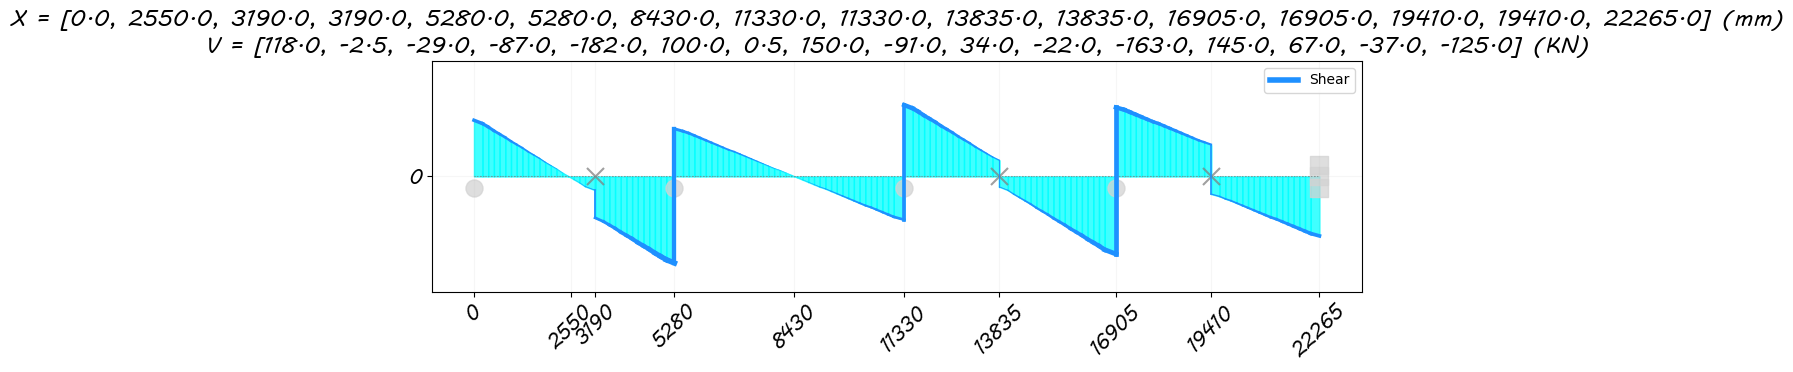

In [24]:
def Plot_Shear( Points, CnB,NB, wBay, V_Shear, V_MxMn ): 
    
    fig, ax = plt.subplots( figsize=(12,3) )
    
    # Undeformed
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=.75, c='gray', ls=':' )
            
    # Shear
    X = V_Shear['X'].tolist()
    V = V_Shear['V'].tolist()    
    LW = abs(  V / max(abs(np.array(V))) ) * 4
    for i in range(len(X)-1):
        x0 = X[i  ]
        x1 = X[i+1]
        y0 = V[i  ] / max(abs(np.array(V))) * .75
        y1 = V[i+1] / max(abs(np.array(V))) * .75
        x  = [x0,x1]
        y  = [y0,y1]
        ax.plot( x, y, lw=(LW[i]+LW[i+1])/2, c='dodgerblue', ls='-' )
        ax.fill_between( x, [0,0], y, color='cyan', alpha=0.75 )
        
    # Supports
    for i in Points.index:
        x = Points.loc[i,'x']
        y = Points.loc[i,'y']
        if   Supports[i]=='fixed' : marker, ec, fc, y = 's', 'lightgray', 'lightgray', y-0.0
        elif Supports[i]=='pinned': marker, ec, fc, y = '^', 'lightgray', 'lightgray', y-0.1
        elif Supports[i]=='roller': marker, ec, fc, y = 'o', 'lightgray', 'lightgray', y-0.1
        elif Supports[i]=='free'  : marker, ec, fc, y = 'x',      'gray',      'gray', y-0.0
        elif Supports[i]=='mid'   : marker, ec, fc, y = '' ,      'gray',      'gray', y-0.0
        ax.scatter( x, y, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        if   Supports[i]=='fixed' :
            ax.scatter( x, y+0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
            ax.scatter( x, y-0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        
    # title
    X = V_MxMn['X'].tolist()
    V = V_MxMn['V'].tolist() 
    plt.title(   'X = '+str(X)+' (mm)'\
              +'\nV = '+str(V)+' (KN)'\
              , font='MV BOLI', fontsize=16 )
    
    # xticks
    Xwalk = [0]
    for i in wBay_Main:
        w = Xwalk[-1] + i 
        Xwalk.append(w)
    Xwalk = list( set( Xwalk + X ))
    xtks = np.array(Xwalk,dtype='f8') 
    ax.set_xticks( xtks )
    plt.xticks(font='MV BOLI',rotation=45,fontsize=14)
    
    # yticks
    Ywalk = [0]
    ytks = np.array(Ywalk,dtype='f8')
    ax.set_yticks( ytks )
    plt.yticks(font='MV BOLI',rotation=0,fontsize=14)
    
    # legend    
    ax.plot( [0,0], [0,0], lw=4, c='dodgerblue', ls='-', label='Shear' )
    plt.legend()
    
    # ylim
    plt.ylim([-1,+1])
    
    # grid
    plt.grid('on',alpha=.1)
    
    # save image
    plt.savefig('Shear.png', dpi=120) 
    plt.show() 
 
    return None


# input --- deformed-shape
Plot_Shear( Points, CnB,NB, wBay, V_Shear, V_MxMn )

#####   
### Plotting Deformed Shape + Moment + Flexture
##### ( set the Scale manually )

In [25]:
# define a function to find 0, Max or Min Moment of Main bays

def Find_M_MxMn( NOP, NB, Beams ):
    
    A = Beams[ ['L','Moment_left','Moment_right'] ].copy() 
    
    X = [0]
    for i in A.index:
        X.append( X[-1]+A.loc[i,'L'] )
        
    A['XL'] = X[:-1]
    A['XR'] = X[+1:]
    A['ML'] = A['Moment_left' ]
    A['MR'] = A['Moment_right']
    A['X' ] = (A['XL']          + A['XR']) / 2
    A['M' ] = (A['Moment_left'] + A['Moment_right']) / 2
    A = A[ ['XL','XR','ML','MR','X','M'] ]
    
    MAX, MIN = [],[]
    if A.loc[0,'M'] < A.loc[1,'M']:   MIN.append([ 0, A.loc[0,'X'], A.loc[0,'M'] ])
    else                          :   MAX.append([ 0, A.loc[0,'X'], A.loc[0,'M'] ])
        
    for i in range(1,NOP-2,1):
    
        i_X_0  = A.loc[i-1,'X']
        i_M_0  = A.loc[i-1,'M']
    
        i_X_1  = A.loc[i,'X']
        i_M_1  = A.loc[i,'M']
    
        i_X_2  = A.loc[i+1,'X']
        i_M_2  = A.loc[i+1,'M']
       
        Left_Slope  = i_M_1 - i_M_0
        Right_Slope = i_M_2 - i_M_1
    
        if   Left_Slope<=0 and 0<=Right_Slope:   MIN.append([ i, i_X_1, i_M_1 ])
        elif Left_Slope>=0 and 0>=Right_Slope:   MAX.append([ i, i_X_1, i_M_1 ])
            
    if A.loc[NB-1,'M'] < A.loc[NB-2,'M']:   MIN.append([ NB-1, A.loc[NB-1,'X'], A.loc[NB-1,'M'] ])
    else                                :   MAX.append([ NB-1, A.loc[NB-1,'X'], A.loc[NB-1,'M'] ])
        
    MIN = pd.DataFrame( MIN, columns=['Idx','X','M'] )
    MAX = pd.DataFrame( MAX, columns=['Idx','X','M'] )
    MIN.index = MIN['Idx']
    MAX.index = MAX['Idx']
    MIN = MIN[['X','M']]
    MAX = MAX[['X','M']]
    
    for i in MIN.index:
        XL = A.loc[i,'XL'];   ML = A.loc[i,'ML']
        XR = A.loc[i,'XR'];   MR = A.loc[i,'MR']
        if ML <= MR: X,M = XL, ML
        else       : X,M = XR, MR
        MIN.loc[i,'X'] = X
        MIN.loc[i,'M'] = int(np.round(M/10**3,0))
    
    for i in MAX.index:
        XL = A.loc[i,'XL'];   ML = A.loc[i,'ML']
        XR = A.loc[i,'XR'];   MR = A.loc[i,'MR']
        if   ML > MR: X,M = XL, ML
        elif ML < MR: X,M = XR, MR
        else        : X,M = (XL+XR)/2, (ML+MR)/2
        MAX.loc[i,'X'] = X
        MAX.loc[i,'M'] = int(np.round(M/10**3,0))

    MIN['M'] = MIN['M'].astype(int)
    MAX['M'] = MAX['M'].astype(int)
    
    # removing duplicates from MAX
    MIN = MIN.drop_duplicates()
    MAX = MAX.drop_duplicates()
    
    return [ MIN, MAX ]

[ M_MIN, M_MAX ] = Find_M_MxMn( NOP, NB, Beams )

In [26]:
# M @ Supports /\
M_MIN

,X,M
Idx,,
0,0.0,0
35,5280.0,-141
74,11330.0,-114
112,16905.0,-167
147,22265.0,-131


In [27]:
# M @ Mid-Spans \/
M_MAX

,X,M
Idx,,
16,2550.0,152
56,8430.0,22
92,13835.0,119
129,19410.0,100


In [28]:
# (auto) define a function to find Flexure Point

def Find_Flexture_Points( NOP, Beams ):
    
    # Moment of all beams
    B = Beams[ ['Moment_left','Moment_right'] ].copy()   
    B['Moment'] = (B['Moment_left']+B['Moment_right'])/2   
    
    # Indexes of points of sign-change 
    I = []                                                 
    for i in range(NOP-3):
        if B.loc[i,'Moment'] * B.loc[i+1,'Moment'] < 0:
            I.append(i)     
            I.append(i+1)   
            I.append(i+2)
            
    # averaging @ points of sign-change
    X  = Points.loc[I,['x']]
    X.index = range( X.shape[0] )
    XX = []
    for i in range( 0, X.shape[0]-1, 3 ):
        xx = (X.loc[i,'x']+X.loc[i+1,'x'])/2  ; XX.append(xx)
        xx = (X.loc[i+1,'x']+X.loc[i+2,'x'])/2; XX.append(xx)
        XX.append(0.0)   # adding Extra 0s for ease of calculations
    
    # applying the average values
    B = B.loc[I,['Moment']]
    B.index = range(B.shape[0])
    B['x'] = XX
    
    # removing Extra 0s
    Keep = []
    for i in B.index:
        if B.loc[i,'x'] > 0.0: Keep.append(i)
    B = B.loc[Keep,:]
    B.index = range(B.shape[0])
    
    # Flexure Points
    Flex = []
    for i in range(0,B.shape[0],2):
        M1 = abs(B.loc[i  ,'Moment'])
        M2 = abs(B.loc[i+1,'Moment'])
        x1 =     B.loc[i  ,'x']
        x2 =     B.loc[i+1,'x']
        x = x1 + (x2-x1)*M1/(M1+M2)
        x = np.round(x,1)
        Flex.append(x)
    
    return Flex

# (auto) Flexure Point
Flex = Find_Flexture_Points( NOP, Beams )
Flex

[4423.2, 7291.0, 9593.8, 12187.3, 15698.2, 18237.6, 21041.8]

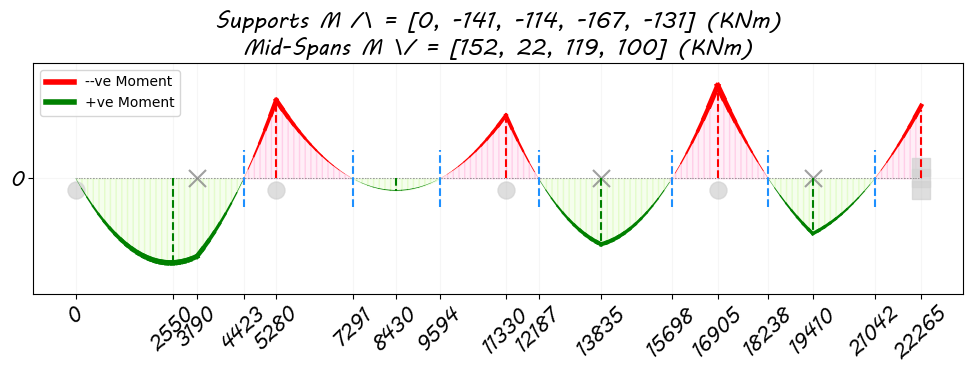

In [29]:
def Plot_Moment( Points, CnB,NB, wBay, M_MIN, M_MAX, Flex ): 
    
    fig, ax = plt.subplots( figsize=(12,3) )
    
    # Undeformed
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=.75, c='gray', ls=':' ) 
    
    # Moment
    Beam_Moment = (Beams['Moment_left']+Beams['Moment_right'])/2
    LW = abs(  Beam_Moment / abs(Beam_Moment).max() ) * 4
    ML = Beams['Moment_left' ] / abs(Beam_Moment).max()
    MR = Beams['Moment_right'] / abs(Beam_Moment).max()
    for i in CnB.index:
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = ML[i]*.75
        y1 = MR[i]*.75
        x = [x0,x1]
        y = [-y0,-y1]
        if Beam_Moment[i] >=0:
            ax.plot( x, y, lw=LW[i], c='g', ls='-' )
            ax.fill_between( x, [0,0], y, color='lawngreen', alpha=0.07 )
        else                 :
            ax.plot( x, y, lw=LW[i], c='r', ls='-' )
            ax.fill_between( x, [0,0], y, color='deeppink' , alpha=0.07 )
        
    for x in Flex:
        x0 = x
        x1 = x
        y0 = -.25
        y1 = +.25
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=1.5, c='dodgerblue', ls='--', marker='' )
        
    for i in M_MIN.index:
        x0 = M_MIN.loc[i,'X']
        x1 = M_MIN.loc[i,'X']
        y0 = 0
        y1 = -M_MIN.loc[i,'M'] / max(abs(M_MIN['M'])) * 0.75
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=1.5, c='r', ls='--', marker='' )
        
    for i in M_MAX.index:
        x0 = M_MAX.loc[i,'X']
        x1 = M_MAX.loc[i,'X']
        y0 = 0
        y1 = -M_MAX.loc[i,'M'] / max(abs(M_MAX['M'])) * 0.75
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=1.5, c='g', ls='--', marker='' )
        

    for i in Points.index:
        x = Points.loc[i,'x']
        y = Points.loc[i,'y']
        if   Supports[i]=='fixed' : marker, ec, fc, y = 's', 'lightgray', 'lightgray', y-0.0
        elif Supports[i]=='pinned': marker, ec, fc, y = '^', 'lightgray', 'lightgray', y-0.1
        elif Supports[i]=='roller': marker, ec, fc, y = 'o', 'lightgray', 'lightgray', y-0.1
        elif Supports[i]=='free'  : marker, ec, fc, y = 'x',      'gray',      'gray', y-0.0
        elif Supports[i]=='mid'   : marker, ec, fc, y = '' ,      'gray',      'gray', y-0.0
        ax.scatter( x, y, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        if   Supports[i]=='fixed' :
            ax.scatter( x, y+0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
            ax.scatter( x, y-0.1, marker=marker, s=150, ec=ec, fc=fc, alpha=0.75 )
        
    # title
    plt.title(   'Supports M /\ = '+str((M_MIN['M']).tolist())+' (KNm)'\
              +'\nMid-Spans M \/ = '+str((M_MAX['M']).tolist())+' (KNm)'\
              , font='MV BOLI', fontsize=16 )
    
    # xticks
    Xwalk = [0]
    for i in wBay_Main:
        w = Xwalk[-1] + i 
        Xwalk.append(w)
    Xwalk = list( set( Xwalk + Flex + M_MIN['X'].tolist() + M_MAX['X'].tolist() ))
    xtks = np.array(Xwalk,dtype='f8') 
    ax.set_xticks( xtks )
    plt.xticks(font='MV BOLI',rotation=45,fontsize=14)
    
    # yticks
    Ywalk = [0]
    ytks = np.array(Ywalk,dtype='f8')
    ax.set_yticks( ytks )
    plt.yticks(font='MV BOLI',rotation=0,fontsize=14)
    
    # legend    
    ax.plot( [0,0], [0,0], lw=4, c='r', ls='-', label='--ve Moment' )
    ax.plot( [0,0], [0,0], lw=4, c='g', ls='-', label='+ve Moment' )
    plt.legend()
    
    # ylim
    plt.ylim([-1,+1])
    
    # grid
    plt.grid('on',alpha=.1)
    
    # save image
    plt.savefig('Moment.png', dpi=120) 
    plt.show() 
 
    return None


# input --- deformed-shape
Plot_Moment( Points, CnB,NB, wBay, M_MIN, M_MAX, Flex )

##### 
### Visualizing Support-Reactions
 - Rx: horizontal reaction (KN), +ve: left to right
 - Ry: vertical reaction (KN), +ve: upward
 - Rz: resistant-moment (KNm), +ve: counter-clockwise 
 - left outer support is Support_1
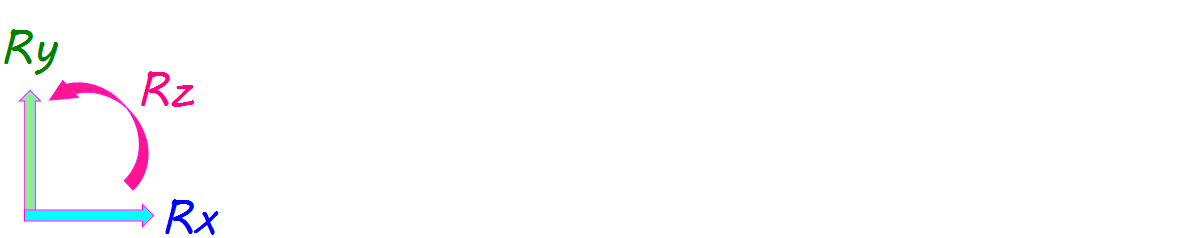

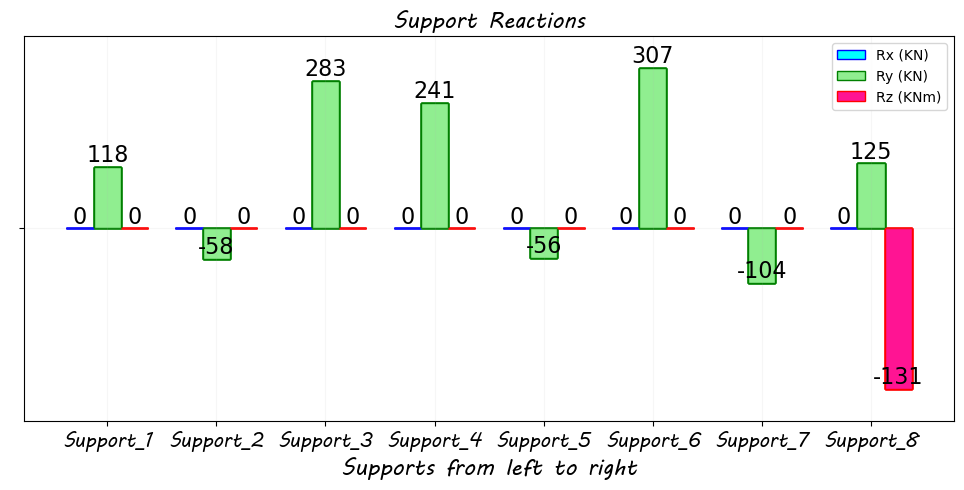

In [30]:
def Plot_Support_Reactions( Rxyz, nPieces ):
    
    eps = 10**(-12)
    
    R, RR = Rxyz.copy(), Rxyz.copy()
    R['Rx'] = R['Rx'].values / (eps+max(np.abs(R['Rx'].values)))
    R['Ry'] = R['Ry'].values / (eps+max(np.abs(R['Ry'].values)))
    R['Rz'] = R['Rz'].values / (eps+max(np.abs(R['Rz'].values)))

    I = [0]
    for i in nPieces: I = I + [I[-1]+i]
    
    R  =  R.loc[I,:]
    RR = RR.loc[I,:]

    R.index  = range( R.shape[0])
    RR.index = range(RR.shape[0])

    n = 1+len(nPieces)
    xR,yR,zR = [],[],[]
    for i in range(0,n):
        xR.append(2*i+0.5)
        yR.append(2*i+1.0)
        zR.append(2*i+1.5)
    
    fig, ax = plt.subplots( figsize=(12,5) )
    for i in range(0,n):
        plt.bar( xR,R['Rx'], width=0.5, color='cyan'      ,  edgecolor='blue'  )
        plt.bar( yR,R['Ry'], width=0.5, color='lightgreen',  edgecolor='green' )
        plt.bar( zR,R['Rz'], width=0.5, color='deeppink'  ,  edgecolor='red'   )
    ax.legend(['Rx (KN)','Ry (KN)','Rz (KNm)'])

    # Decoration
    plt.title( 'Support Reactions',font='MV BOLI',fontsize=16)
    plt.xlabel( 'Supports from left to right',font='MV BOLI',fontsize=16)

    for i, val in enumerate( np.round( RR['Rx'].values, 0 ) ): 
        plt.text(xR[i], R['Rx'][i], int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':16})
    for i, val in enumerate( np.round( RR['Ry'].values, 0 ) ): 
        plt.text(yR[i], R['Ry'][i], int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':16})
    for i, val in enumerate( np.round( RR['Rz'].values/10**3, 0 ) ):
        plt.text(zR[i], R['Rz'][i], int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':16})

    # xtick
    xtick_labels = []
    for i in range(1,n+1):
        xtick_labels.append('Support_'+str(i))
    ax.set_xticks( yR ) 
    ax.set_xticklabels( xtick_labels )
    plt.xticks(font='MV BOLI',rotation=0,fontsize=14)  

    # ytick
    ytick_labels = [' '] 
    ax.set_yticks( [0] ) 
    ax.set_yticklabels( ytick_labels ) 
    
    # ylim
    plt.ylim([-1.2,+1.2])
    
    # grid
    plt.grid('on',alpha=.1)
    
    # save image
    plt.savefig('Support_Reactions.png', dpi=120) 
    plt.show()
    
    return None

# Visualizing Support Reactions
Plot_Support_Reactions( Rxyz, nPieces )

##### 

##### 
### Checking Accuracy
##### Acc = Sum( Ry ) / Sum( dist. load + Point load )

In [31]:
# (auto) 
def Find_Accuracy( wBay_Main, W_Beams, Supports, NF, R ):
    LOAD = 0  # (KN)  Applied Load
    REAC = 0  # (KN)  Caculated Reactions

    for i in range( len(Supports) ):
        if ( (Supports[i] == 'free') or (Supports[i] == 'mid') ):   LOAD = LOAD + NF.loc[3*i+1,'Load'     ]
        else                                                    :   REAC = REAC +  R.loc[3*i+1,'Reactions']
    for i in range( len(wBay_Main) )                            :   LOAD = abs(LOAD) + W_Beams[i] * wBay_Main[i]
    
    Accuracy = np.round( (REAC/LOAD)*100, 1 )
    return Accuracy
    
# (auto)
Accuracy = Find_Accuracy( wBay_Main, W_Beams, Supports, NF, R )
print( 'Accuracy  =  ' + str(Accuracy) + ' %' )

Accuracy  =  97.6 %


##### 
### Important DataFrames

In [32]:
#Uxyz        # Global Displacements 
#Rxyz        # Support Reactions
#Columns     # Internal Member Forces
#Beams       # Internal Member Forces
#Diagonals   # Internal Member Forces

##### 
### Important Visualizers

In [33]:
##### #Shape( Points, CnC, CnB, CnD, wBay, hStory )   # Undeformed Shape
#Plot_Deformed( Scale, Undeformed_YN, Points, Uxyz, CnC,CnB,CnD, NC,NB,ND, wBay,hStory )   # Deformed Shape
#Plot_Support_Reactions( Rxyz, nBay )   # Visualizing Support Reactions

##### 

##### 